# Case Study 3: Computational Methods in Finance

# Charles Laferte - cl4249

In [1]:
import modulesForCalibration as mfc

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import scipy.integrate as integrate
import pandas as pd

from scipy.optimize import fmin, fmin_bfgs

import cmath
import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from tqdm import tqdm
from matplotlib import cm

## Import data

In [2]:
'''Standard & Poors 500 Index,Last: 4104.8301,Change:  -4.1099
Date: 12 avril 2023 √† 15:44 UTC‚àí4,Bid: 4104.1299,Ask: 4105.5498,Size: 1*1,Volume: 0'''

'Standard & Poors 500 Index,Last: 4104.8301,Change:  -4.1099\nDate: 12 avril 2023 √† 15:44 UTC‚àí4,Bid: 4104.1299,Ask: 4105.5498,Size: 1*1,Volume: 0'

Start_date

In [3]:
# Set the start date to compute the maturities
date_str = "2023-04-12"
# create a datetime object from the date string
start_date = datetime.strptime(date_str, "%Y-%m-%d")

Spot Price

In [4]:
S0 = 4104.8301

Rates

In [5]:
r = 0.0485

In [6]:
q = 0.0331026

Import market data

In [7]:
df_price = pd.read_csv("spx_4.csv", index_col=0)


In [8]:
#Filtrer les SPX... qui ne sont pas des SPXW...
mask = df_price['Calls'].str.contains('SPXW', case=False, na=False)
df_price = df_price[mask]

In [9]:
df_price.columns

Index(['Calls', 'Last Sale', 'Net', 'Bid', 'Ask', 'Volume', 'IV', 'Delta',
       'Gamma', 'Open Interest', 'Strike', 'Puts', 'Last Sale.1', 'Net.1',
       'Bid.1', 'Ask.1', 'Volume.1', 'IV.1', 'Delta.1', 'Gamma.1',
       'Open Interest.1'],
      dtype='object')

In [10]:
df_price[['Strike']]

Strike
Expiration Date        
Wed Apr 12 2023    3450
Wed Apr 12 2023    3600
Wed Apr 12 2023    3625
Wed Apr 12 2023    3650
Wed Apr 12 2023    3675
...                 ...
Fri Jun 30 2023    4700
Fri Jun 30 2023    4750
Fri Jun 30 2023    4800
Fri Jun 30 2023    5000
Fri Jun 30 2023    5025

[3248 rows x 1 columns]

In [11]:
callPrices = df_price[['Strike']] #['Last Sale','Strike']]
# Compute the mid-price
callPrices['Price'] = np.abs(df_price['Bid'].array + df_price['Ask'].array)/2
# Convert index to datetime
callPrices.index = pd.to_datetime(callPrices.index)

# Getting the weights inversely proportional to bid-ask spread
callPrices['w'] = np.abs(1/(df_price['Bid'].array - df_price['Ask'].array))

# define a function to compute the difference in days between two dates
def date_diff(date):
    diff = (date - start_date)
    return diff.days

# create a new column in the DataFrame that contains the difference in days
callPrices['Maturity'] = callPrices.index.to_series().apply(date_diff)
callPrices['Maturity'] = callPrices['Maturity']/252# trading days.../365.25
#callPrices['Strike'] = np.log(callPrices['Strike'].array)

callPrices = callPrices[callPrices['Strike']>=S0]

# drop today
callPrices = callPrices[callPrices['Maturity']!=0]
#579 avec zero mat included

In [12]:
putPrices = df_price[['Strike']] #['Last Sale','Strike']]
# Compute the mid-price
putPrices['Price'] = np.abs(df_price['Bid.1'].array + df_price['Ask.1'].array)/2
# Convert index to datetime
putPrices.index = pd.to_datetime(putPrices.index)

# Getting the weights inversely proportional to bid-ask spread
putPrices['w'] = np.abs(1/(df_price['Bid.1'].array - df_price['Ask.1'].array))

# define a function to compute the difference in days between two dates
def date_diff(date):
    diff = (date - start_date)
    return diff.days

# create a new column in the DataFrame that contains the difference in days
putPrices['Maturity'] = putPrices.index.to_series().apply(date_diff)
putPrices['Maturity'] = putPrices['Maturity']/365.25
#callPrices['Strike'] = np.log(callPrices['Strike'].array)

putPrices = putPrices[putPrices['Strike']<=S0]

# drop today
putPrices = putPrices[putPrices['Maturity']!=0]
#579 avec zero mat included

Visualize market data

In [13]:
callPrices

Strike   Price          w  Maturity
Expiration Date                                     
2023-04-13         4105  16.350  10.000000  0.002738
2023-04-13         4110  13.750  10.000000  0.002738
2023-04-13         4115  11.400   5.000000  0.002738
2023-04-13         4120   9.300   5.000000  0.002738
2023-04-13         4125   7.450  10.000000  0.002738
...                 ...     ...        ...       ...
2023-06-30         4700   1.775   6.666667  0.216290
2023-06-30         4750   1.175   6.666667  0.216290
2023-06-30         4800   0.825   6.666667  0.216290
2023-06-30         5000   0.275   6.666667  0.216290
2023-06-30         5025   0.225   6.666667  0.216290

[1069 rows x 4 columns]

In [14]:
putPrices

Strike   Price          w  Maturity
Expiration Date                                     
2023-04-13         3450   0.025  20.000000  0.002738
2023-04-13         3500   0.025  20.000000  0.002738
2023-04-13         3575   0.025  20.000000  0.002738
2023-04-13         3600   0.025  20.000000  0.002738
2023-04-13         3625   0.025  20.000000  0.002738
...                 ...     ...        ...       ...
2023-06-30         4075  87.050   1.428571  0.216290
2023-06-30         4080  88.400   1.666667  0.216290
2023-06-30         4085  89.800   1.666667  0.216290
2023-06-30         4090  91.250   1.428571  0.216290
2023-06-30         4100  94.150   1.428571  0.216290

[2077 rows x 4 columns]

In [15]:
callPrices.describe()

Strike        Price            w     Maturity
count  1069.000000  1069.000000  1069.000000  1069.000000
mean   4267.970065    26.481805     5.603212     0.075489
std     152.757105    32.132976     4.964135     0.061322
min    4105.000000     0.025000     1.250000     0.002738
25%    4160.000000     1.950000     2.500000     0.024641
50%    4225.000000    13.550000     3.333333     0.054757
75%    4325.000000    40.550000     6.666667     0.120465
max    5200.000000   162.600000    20.000000     0.216290

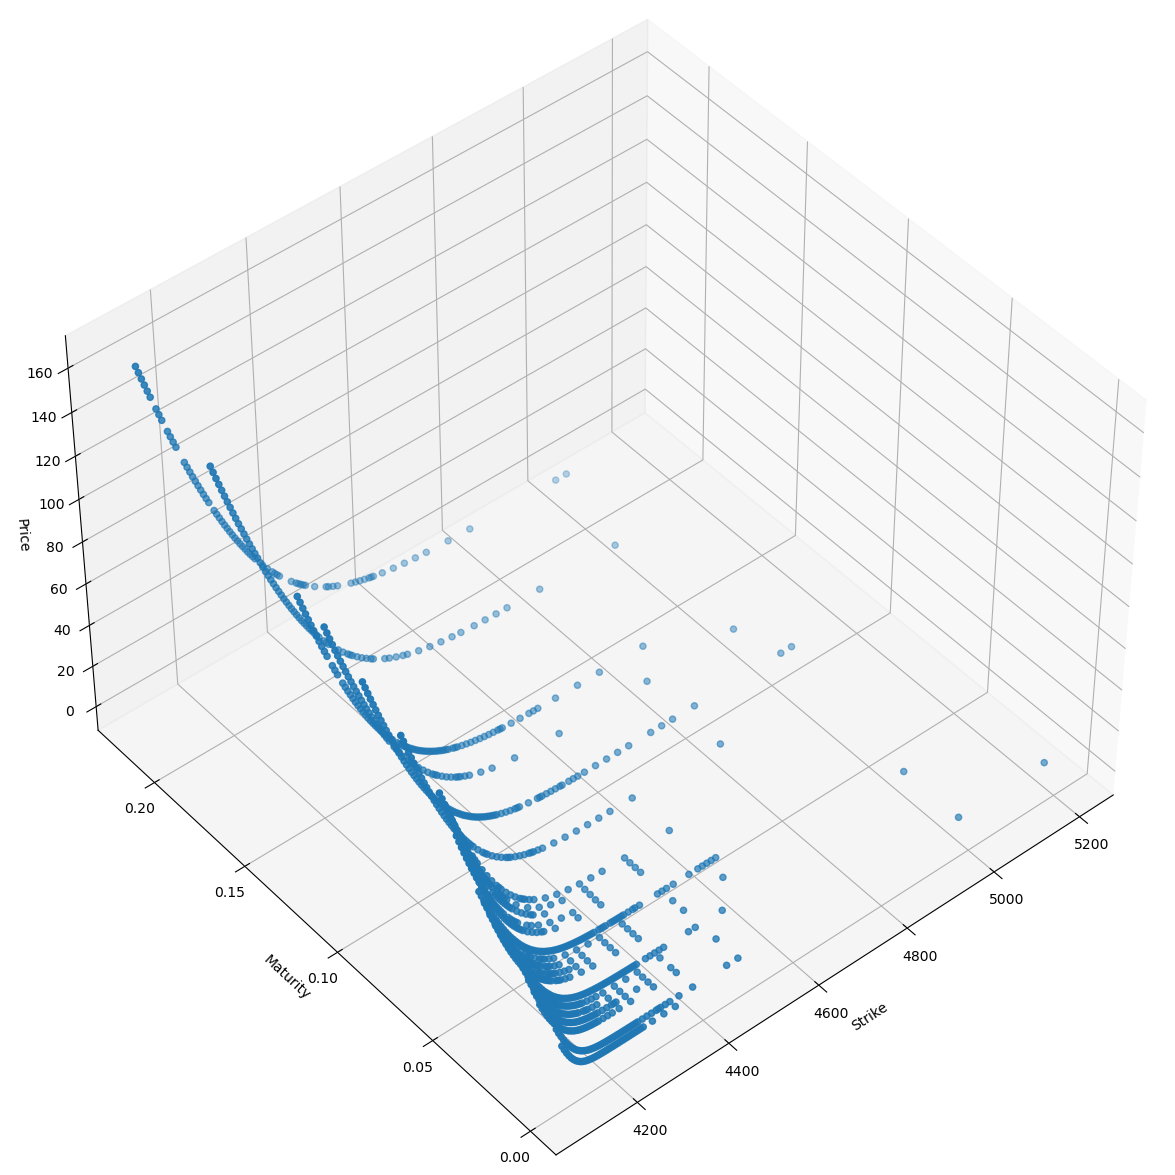

In [16]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'], cmap=cm.coolwarm)
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.show()

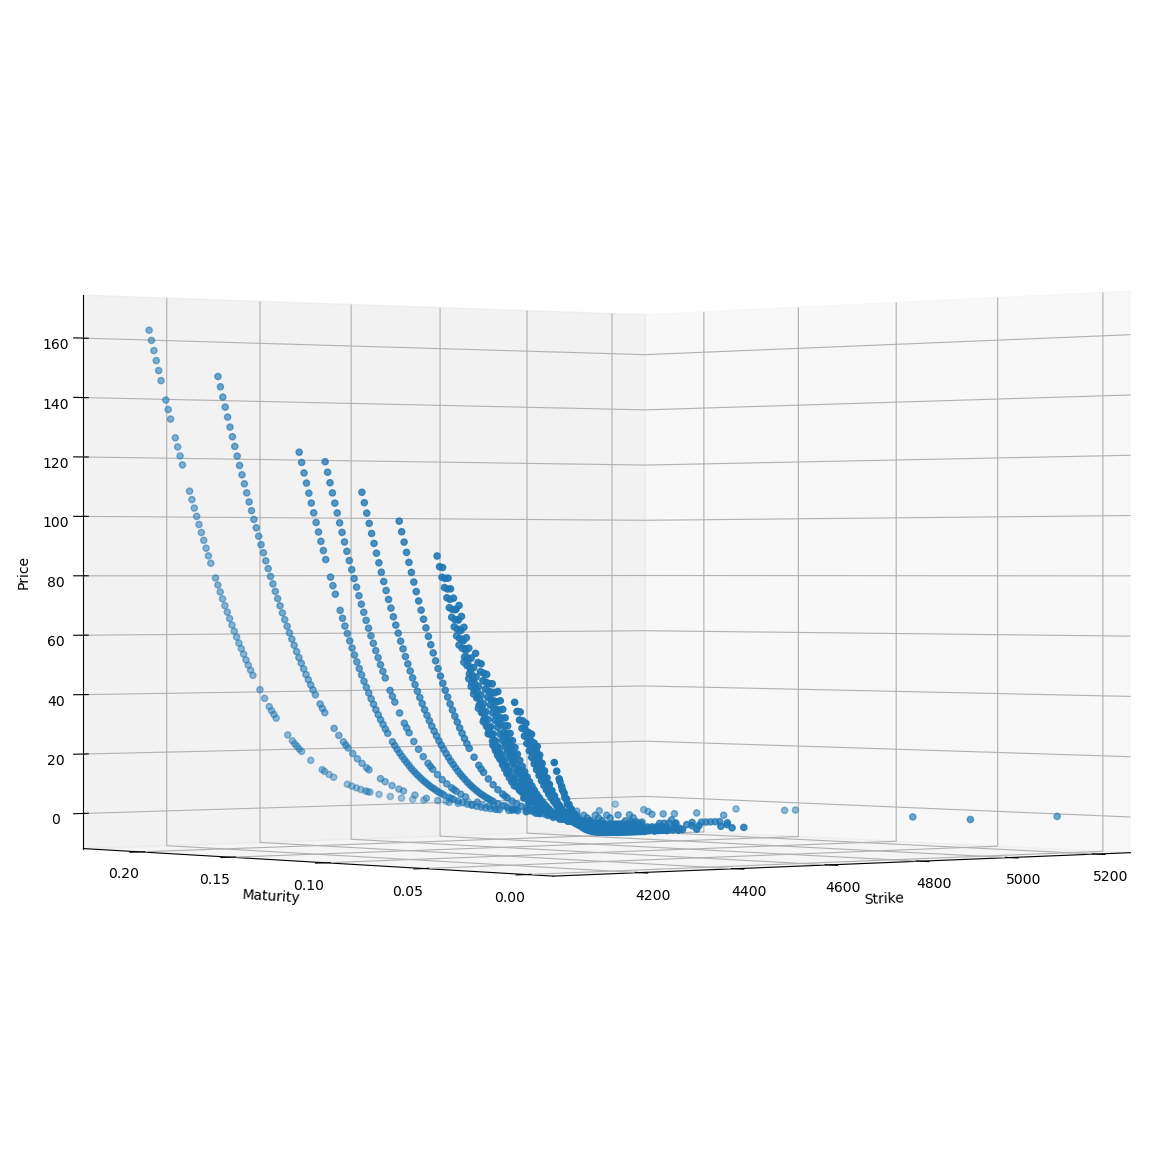

In [17]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'], cmap=cm.coolwarm)
ax.view_init(elev=0, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.show()

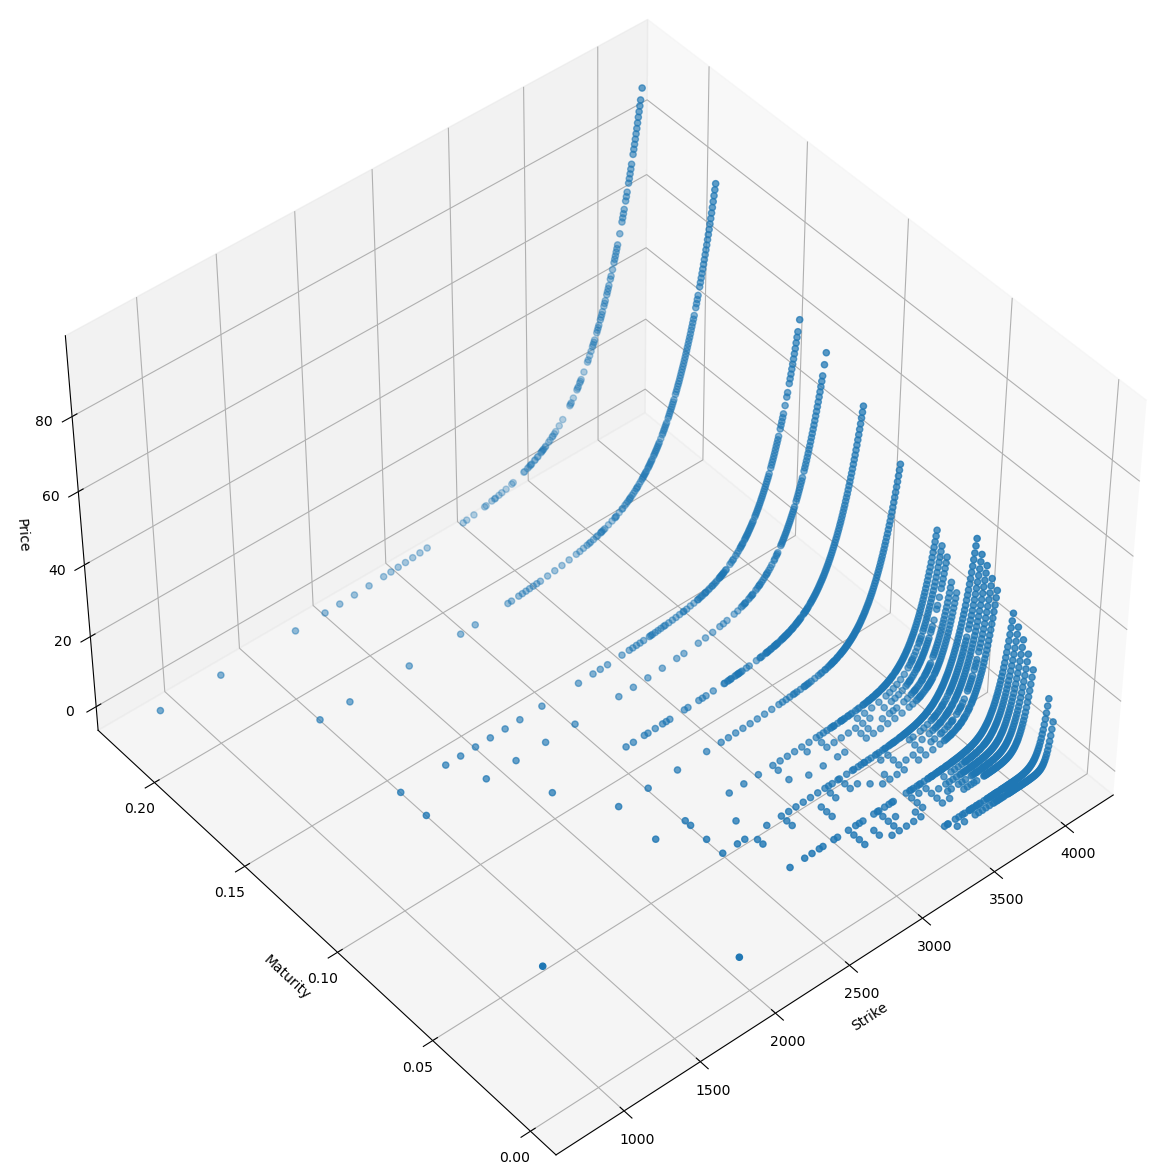

In [18]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(putPrices['Strike'], putPrices['Maturity'], putPrices['Price'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'], cmap=cm.coolwarm)
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.show()

### Building the marketprice matrix

In [19]:
strikes = pd.Series(callPrices['Strike'].unique()).sort_values().to_list()
maturities = pd.Series(callPrices['Maturity'].unique()).sort_values().to_list()
lenK = len(strikes)
lenT = len(maturities)

strike_m = []

#for i in strikes: 
for j in maturities: 
        #print(i, j)
        strike_m_temp = callPrices[(callPrices['Maturity']==j)]['Strike'].to_list()
        #marketPrices_temp = callPrices[(callPrices['Maturity']==j)]['Price'].to_list()
        
        #marketPrices.append(marketPrices_temp)
        strike_m.append(strike_m_temp)
        
strikes = set(strike_m[0])
for i in range(1,len(strike_m)):
    strikes = strikes.intersection(set(strike_m[i]))

strikes = list(strikes)
strikes = sorted(strikes)
print(strikes)

marketPrices = np.zeros((len(strikes), len(maturities)))
w = np.zeros((len(strikes), len(maturities)))
for j in range(len(maturities)):
    for i in range(len(strikes)):
        #print(maturities[j])
        #print(strikes[i])
        #print(callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['Price'][0])
        marketPrices[i,j] = callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['Price'][0]
        w[i,j] = callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['w'][0]
        
marketPrices = marketPrices.T
w = w.T

[4105, 4110, 4120, 4125, 4130, 4140, 4150, 4170, 4190, 4200, 4210, 4220, 4225, 4230, 4250, 4275, 4300]


In [20]:
strikes_p = pd.Series(putPrices['Strike'].unique()).sort_values().to_list()
maturities_p = pd.Series(putPrices['Maturity'].unique()).sort_values().to_list()
lenK_p = len(strikes_p)
lenT_p = len(maturities_p)

strike_m_p = []

#for i in strikes: 
for j in maturities_p: 
        #print(i, j)
        strike_m_temp_p = putPrices[(putPrices['Maturity']==j)]['Strike'].to_list()
        #marketPrices_temp = callPrices[(callPrices['Maturity']==j)]['Price'].to_list()
        
        #marketPrices.append(marketPrices_temp)
        strike_m_p.append(strike_m_temp_p)
        
strikes_p = set(strike_m_p[0])
for i in range(1,len(strike_m_p)):
    strikes_p = strikes_p.intersection(set(strike_m_p[i]))

strikes_p = list(strikes_p)
strikes_p = sorted(strikes_p)
#print(strikes_p)
#print(maturities_p)
marketPrices_p = np.zeros((len(strikes_p), len(maturities_p)))
w_p = np.zeros((len(strikes_p), len(maturities_p)))
for j in range(len(maturities_p)):
    for i in range(len(strikes_p)):
        #print(maturities_p[j])
        #print(strikes_p[i])
        #print(putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['Price'][0])
        marketPrices_p[i,j] = putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['Price'][0]
        w_p[i,j] = putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['w'][0]
        
marketPrices_p = marketPrices_p.T
w_p = w_p.T

# 1. Heston and VGSA parameters via calibration 

In [21]:
#Generating Option Price Surface Under A model from the list         
def generic_CF(u, params, T, model):
    
    if (model == 'GBM'):
        
        sig = params[0];
        mu = np.log(S0) + (r-q-sig**2/2)*T;
        a = sig*np.sqrt(T);
        phi = np.exp(1j*mu*u-(a*u)**2/2);
        
    elif(model == 'Heston'):
        
        kappa  = params[0];
        theta  = params[1];
        sigma  = params[2];
        rho    = params[3];
        v0     = params[4];

        tmp = (kappa-1j*rho*sigma*u);
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2);
        
        pow1 = 2*kappa*theta/(sigma**2);

        numer1 = (kappa*theta*T*tmp)/(sigma**2) + 1j*u*T*r + 1j*u*math.log(S0); # manque un q ici en fait (dans le python file)
        log_denum1 = pow1 * np.log(np.cosh(g*T/2)+(tmp/g)*np.sinh(g*T/2));
        tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp);
        log_phi = numer1 - log_denum1 - tmp2;
        phi = np.exp(log_phi);

    elif (model == 'VG'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];

        if (nu == 0):
            mu = math.log(S0) + (r-q - theta -0.5*sigma**2)*T;
            phi  = math.exp(1j*u*mu) * math.exp((1j*theta*u-0.5*sigma**2*u**2)*T);
        else:
            mu  = math.log(S0) + (r-q + math.log(1-theta*nu-0.5*sigma**2*nu)/nu)*T;
            phi = cmath.exp(1j*u*mu)*((1-1j*nu*theta*u+0.5*nu*sigma**2*u**2)**(-T/nu));
            
    elif (model == 'VGSA'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];
        kappa  = params[3]; 
        eta    = params[4];
        lbda   = params[5];
        
        #cf if mu = 0 ce qu'on fait
        #if (nu == 0):
        psi_VG_i = - np.log(1-theta*nu-sigma**2*nu*0.5)/nu
        psi_VG_u = - np.log(1-1j*u*theta*nu+sigma**2*nu*u**2*0.5)/nu
        
        tp = 1j*u * (np.log(S0) + (r-q)*T)
        
        def A(v):
            ga = np.sqrt(kappa**2 - 2*lbda**2*1j*v)
            A_t_u = np.exp(kappa**2*eta*T/(lbda**2))/((np.cosh(ga*T/2)+(kappa/ga)*np.sinh(ga*T/2))**(kappa*2*eta/(lbda**2)))
            return(A_t)
        def B(v):
            ga = np.sqrt(kappa**2 - 2*lbda**2*1j*v)
            B_t = 2*1j*v / (kappa+ ga/np.tanh(ga*T/2))
            return(B_t)
        
        A_t_u = np.exp(kappa**2*eta*T/(lbda**2))/((np.cosh(ga*T/2)+(kappa/ga)*np.sinh(ga*T/2))**(kappa*2*eta/(lbda**2)))
        B_t_u = 2*1j*u / (kappa+ ga/np.tanh(ga*T/2))
        
        phi_up = A(-1j*psi_VG_u)*np.exp(B(-j*psi_VG_u)/nu)
        phi_down = A(-1j*psi_VG_i)*np.exp(B(-j*psi_VG_i)/nu)
        
        phi = np.exp(tp)*phi_up/phi_down
        
    return phi

In [22]:
def genericFFT(params, T, model):
    
    # forming vector x and strikes km for m=1,...,N
    km = []
    xX = []
    
    # discount factor
    df = math.exp(-r*T)
    
    for j in range(N):
        
        nuJ=j*eta
        km.append(beta+j*lda)
        
        psi_nuJ = df*generic_CF(nuJ-(alpha+1)*1j, params, T, model)/((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))
        if j == 0:
            wJ = (eta/2)
        else:
            wJ = eta
        
        xX.append(cmath.exp(-1j*beta*nuJ)*psi_nuJ*wJ)
     
    yY = np.fft.fft(xX)
    
    cT_km = []    
    for i in range(N):
        multiplier = math.exp(-alpha*km[i])/math.pi
        cT_km.append(multiplier*np.real(yY[i]))
    
    return km, cT_km


In [23]:
# function for the search: 
def myRange(start, finish, increment):
    while (start <= finish):
        yield start
        start += increment
        
def objFunc(v, x0, x1, x2):
    # Paraboloid centered on (x, y), with scale factors (10, 20) and minimum 30
    return 10.0*(v[0]-x0)**2 + 20.0*(v[1]-x1)**2 + 30.0*(v[2]-x2)**2 + 40.0

Here, for calibration, we will use Gradient-Based routines e.g. the Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm.

# 1.1 Heston model:

#### Parameters
κ is the mean reversion speed, 
θ is the long run variance,
σ is the volatility of the volatility.

## 1.1.a Heston with equal weights on Call Prices

In [24]:
params = [2.3,     0.046,   0.0825, -0.53,    0.054]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model ='Heston'

def callbackF(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
[xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(
        mfc.eValue,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF,
        maxiter=20,
        full_output=True, 
        retall=False)

26.917603936385817
26.91760393238787
26.917605278349026
26.91760387195445
26.917603944359737
26.917614794097368
12.991818243251787
12.991818272468665
12.991816692672232
12.991818172188792
12.991818252744512
12.991830028417139
50.96669946226243
50.96669953341327
50.96670062854896
50.96669940556747
50.966699471221276
50.96669071849897
106.9613422166266
106.96134225676293
106.96134143365141
106.96134216789483
106.96134222398355
106.96134829815324
60.34533238532081
60.345332400430465
60.34533132890937
60.345332330967906
60.34533239266174
60.345340605117244
36.43331597979236
36.433315994014805
36.43331469956929
36.433315919157266
36.43331598773015
36.433305994419854
12.23468722374694
12.234687172132482
12.23468899417724
12.234687264182828
12.234687219365162
12.234671105503251
6.432774378930434
6.432774403368332
6.432773297313222
6.432774317443811
6.432774387857382
6.4327813583364675
 
i = 1
x_i = [ 2.30037256 -0.07905618  0.08850429 -0.53074308 -0.95781907]
6.432774378930434
f_i = 6.4327743

In [25]:
xopt

array([ 2.35948156, -0.07959283,  0.59916615, -1.00043828, -0.95522165])

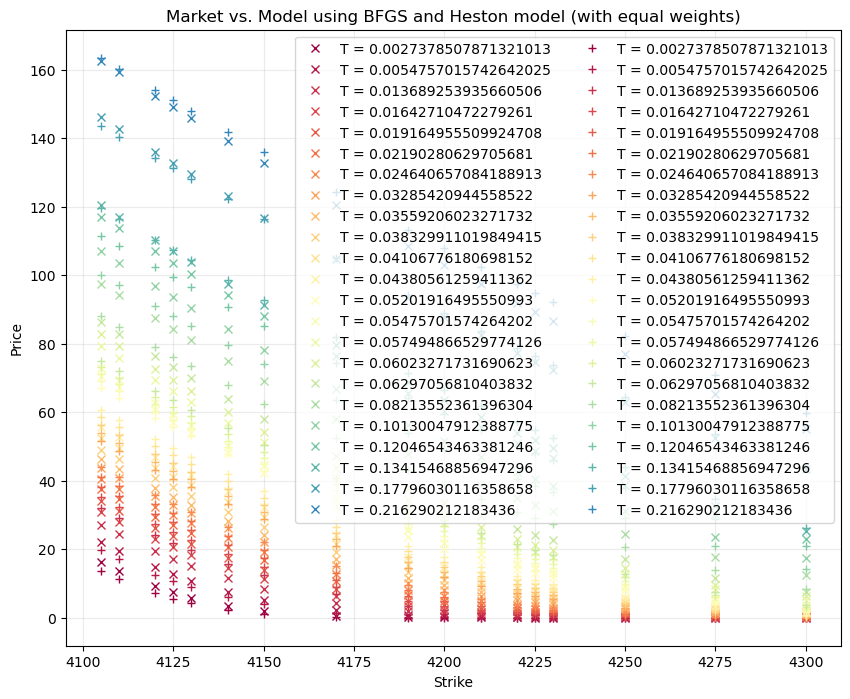

In [26]:
params2 = xopt
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with equal weights)')
plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


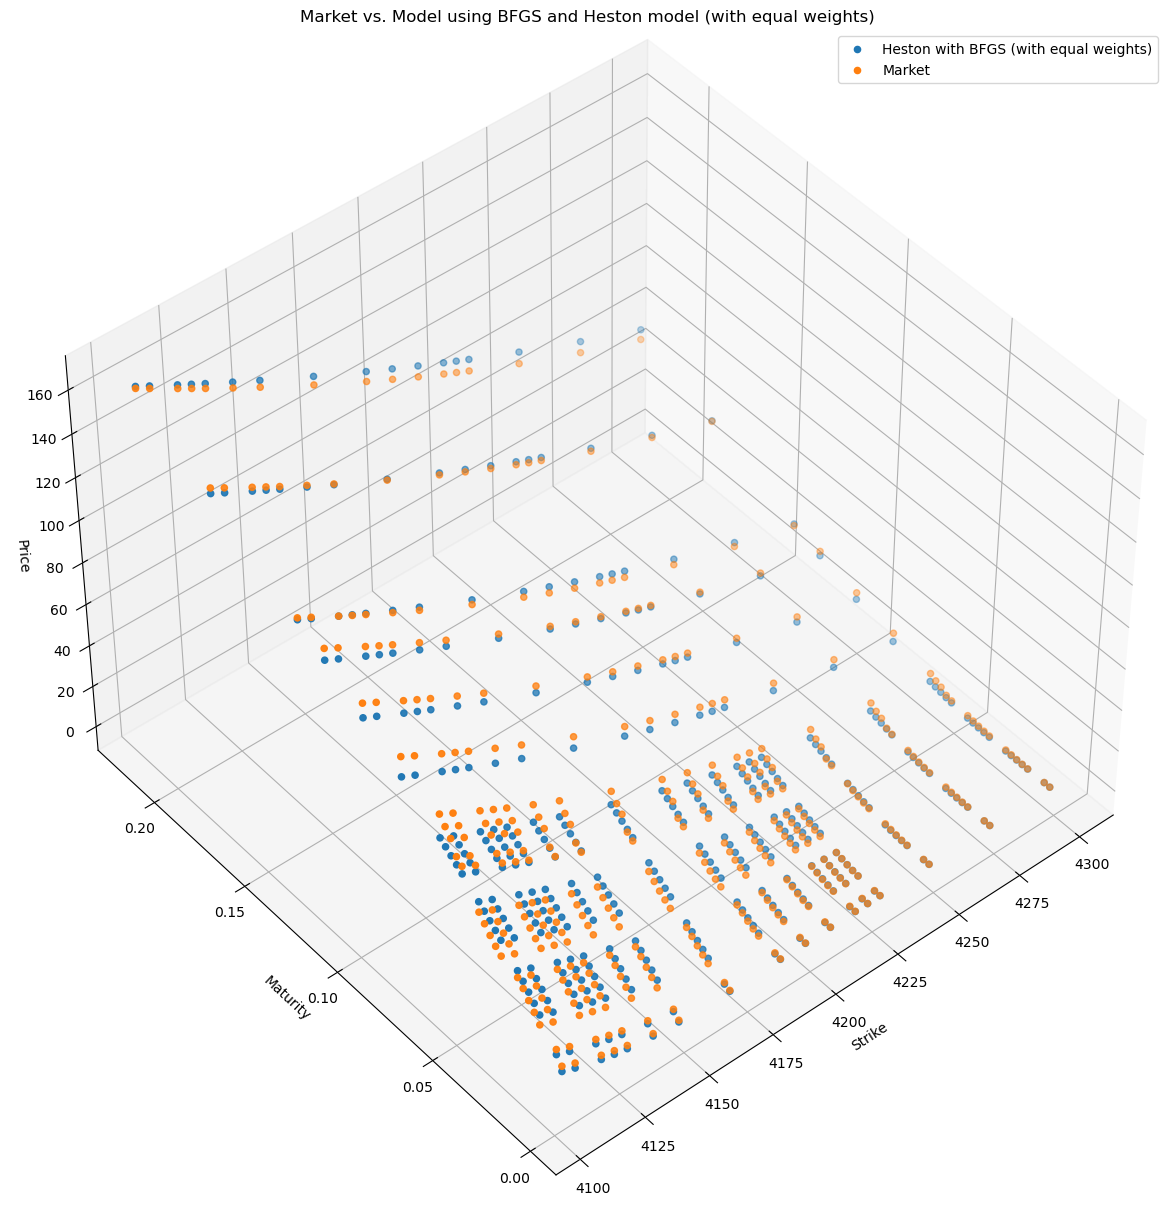

In [27]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices.T, label='Heston with BFGS (with equal weights)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with equal weights)')
plt.legend()

plt.show()

## 1.1.b Heston with weights inversely proportional to bid-ask spread on Call prices

In [28]:
params = [2.3,     0.046,   0.0825, -0.53,    0.054]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model ='Heston'

def callbackF_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model, w)

num_iter = 1
[xopt_w, fopt_w, gopt_w, Bopt_w, func_calls_w, grad_calls_w, warnflg_w] = fmin_bfgs(
        mfc.eValue_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_w,
        maxiter=20,
        full_output=True, 
        retall=False)

20.546802346241865
20.546802343831924
20.546803146890287
20.546802296350254
20.546802352816727
20.54681037116938
6.876877062307984
6.8768770706721964
6.876876298266712
6.876877008109876
6.876877070311694
6.876885285293197
47.40311192366545
47.403111990058726
47.40311256921619
47.40311188245921
47.40311193079521
47.403105982508144
84.52840451960896
84.52840452603287
84.52840406316486
84.52840448190877
84.52840452562069
84.52840902888315
50.095964967886324
50.09596496404388
50.095964365207166
50.09596492574039
50.095964973963135
50.09597088771282
22.26013035452369
22.26013035725458
22.260129551782597
22.26013030495832
22.26013036147372
22.26012247660815
10.780663977683824
10.780663949118116
10.780665438074763
10.780664016429032
10.780663973091626
10.780651161065522
4.031851711046701
4.031851710957969
4.031851726950896
4.0318516807707185
4.031851716428797
4.031853421906533
 
i = 1
x_i = [ 2.30030394 -0.05497772  0.08879233 -0.53082922 -0.95810324]
4.031851711046701
f_i = 4.031851711046701

In [29]:
xopt_w

array([ 4.26196148, -0.05999494,  0.58630809, -1.01179205, -0.95722616])

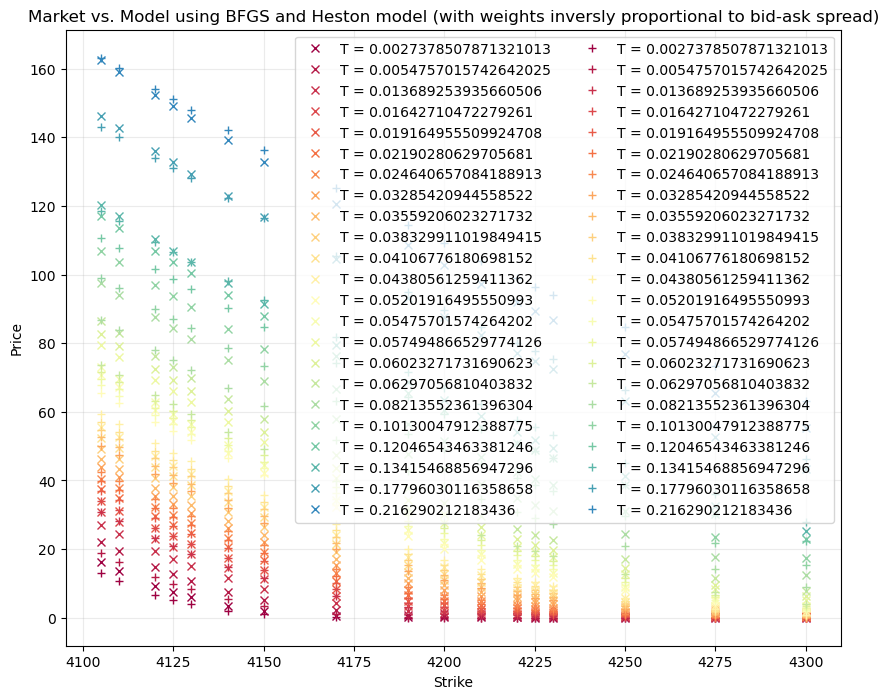

In [30]:
params2 = xopt_w
lenT = len(maturities)
lenK = len(strikes)
modelPrices_w = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_w[i,j] = cT_km[0]

# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_w[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread)')
plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


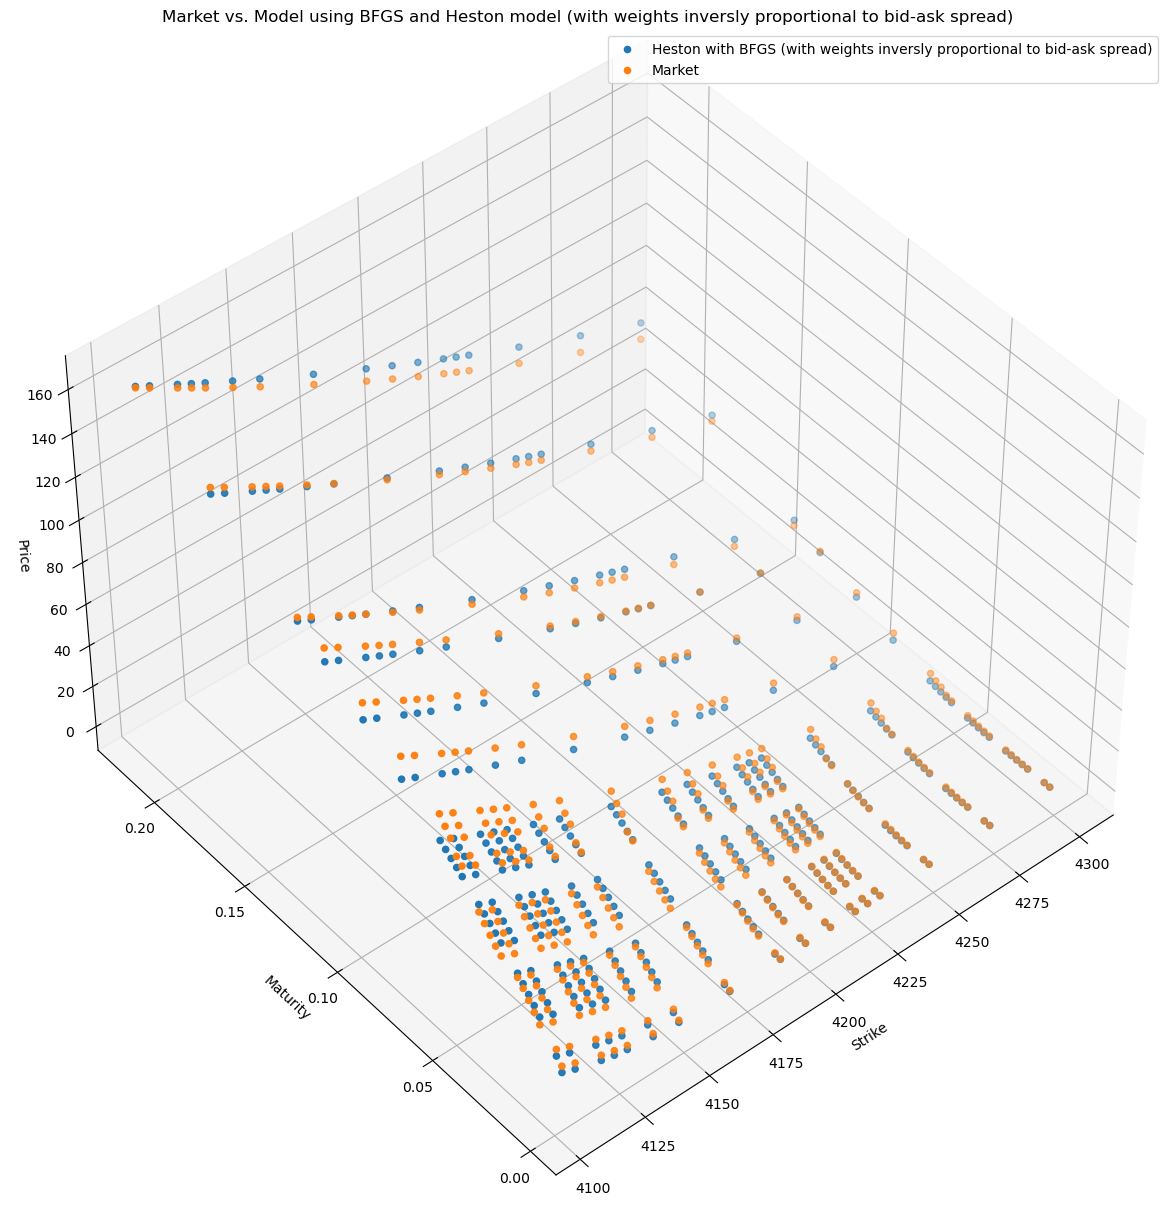

In [31]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices_w.T, label='Heston with BFGS (with weights inversly proportional to bid-ask spread)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread)')

plt.legend()

plt.show()

## 1.1.c Heston with equal weights on Call & Put prices

In [32]:
params = [ 2.34548424, 0.06375792, 0.59865706, -0.43626748, -0.95937438]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

r = 0.0485
q = 0.03310264838967327

model ='Heston'

def callbackF_full(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model)

num_iter = 1
[xopt_pc, fopt_pc, gopt_pc, Bopt_pc, func_calls_pc, grad_calls_pc, warnflg_pc] = fmin_bfgs(
        mfc.eValuefull,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full,
        maxiter=20,
        full_output=True, 
        retall=False)

 
i = 1
x_i = [ 2.34547637  0.06327202  0.59865338 -0.43623731 -0.96281965]
f_i = 10.664129184177813
 
i = 2
x_i = [ 2.34561038  0.05224145  0.58476893 -0.41892556 -0.96145466]
f_i = 10.581207242590827
 
i = 3
x_i = [ 2.34860803  0.04854858  0.46347785 -0.27171281 -0.96200312]
f_i = 9.856611114317921
 
i = 4
x_i = [ 2.30236594  0.04025805  0.20175872  0.11680907 -0.9624521 ]
f_i = 9.01451520755
 
i = 5
x_i = [ 2.18171845  0.06120302  0.60523637  0.88626161 -0.96215728]
f_i = 8.219633646350761
 
i = 6
x_i = [ 2.18295688  0.06308904  0.63660412  0.91057553 -0.96222963]
f_i = 8.196553166805044
 
i = 7
x_i = [ 2.18309035  0.06448111  0.63468301  0.86719437 -0.96255072]
f_i = 8.160828737178342
 
i = 8
x_i = [ 2.17446657  0.06709596  0.6463773   0.83203293 -0.96309211]
f_i = 8.142135808656153
 
i = 9
x_i = [ 2.16935444  0.06628563  0.65413944  0.81862544 -0.96302117]
f_i = 8.140135440610125
 
i = 10
x_i = [ 2.15342294  0.06605197  0.66724578  0.81997676 -0.96306048]
f_i = 8.138684389350624
 

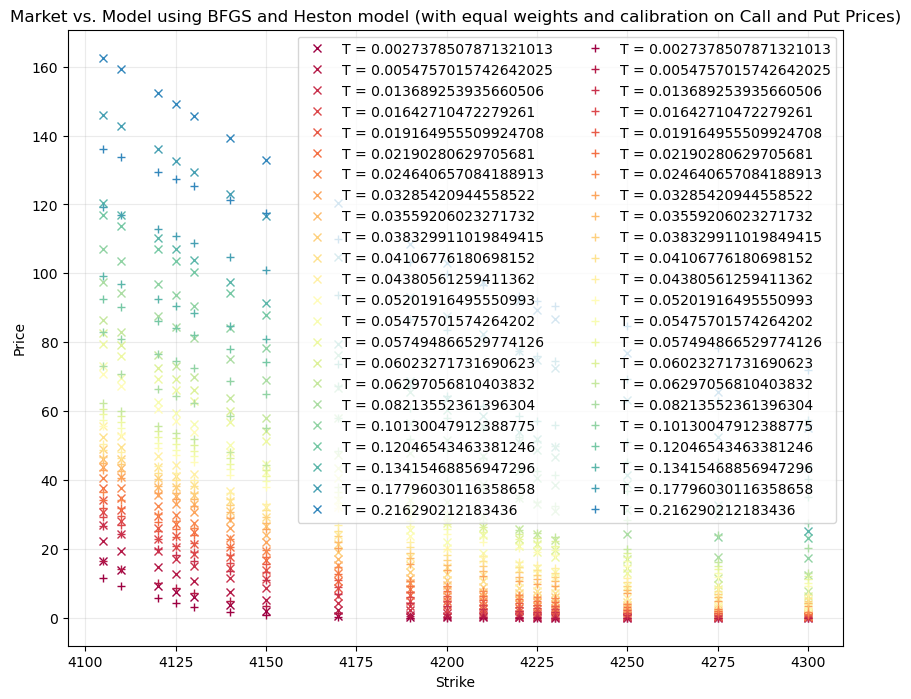

In [33]:
params2 = xopt_pc
lenT = len(maturities)
lenK = len(strikes)
modelPrices_pc = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_pc[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_pc[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with equal weights and calibration on Call and Put Prices)')
#plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


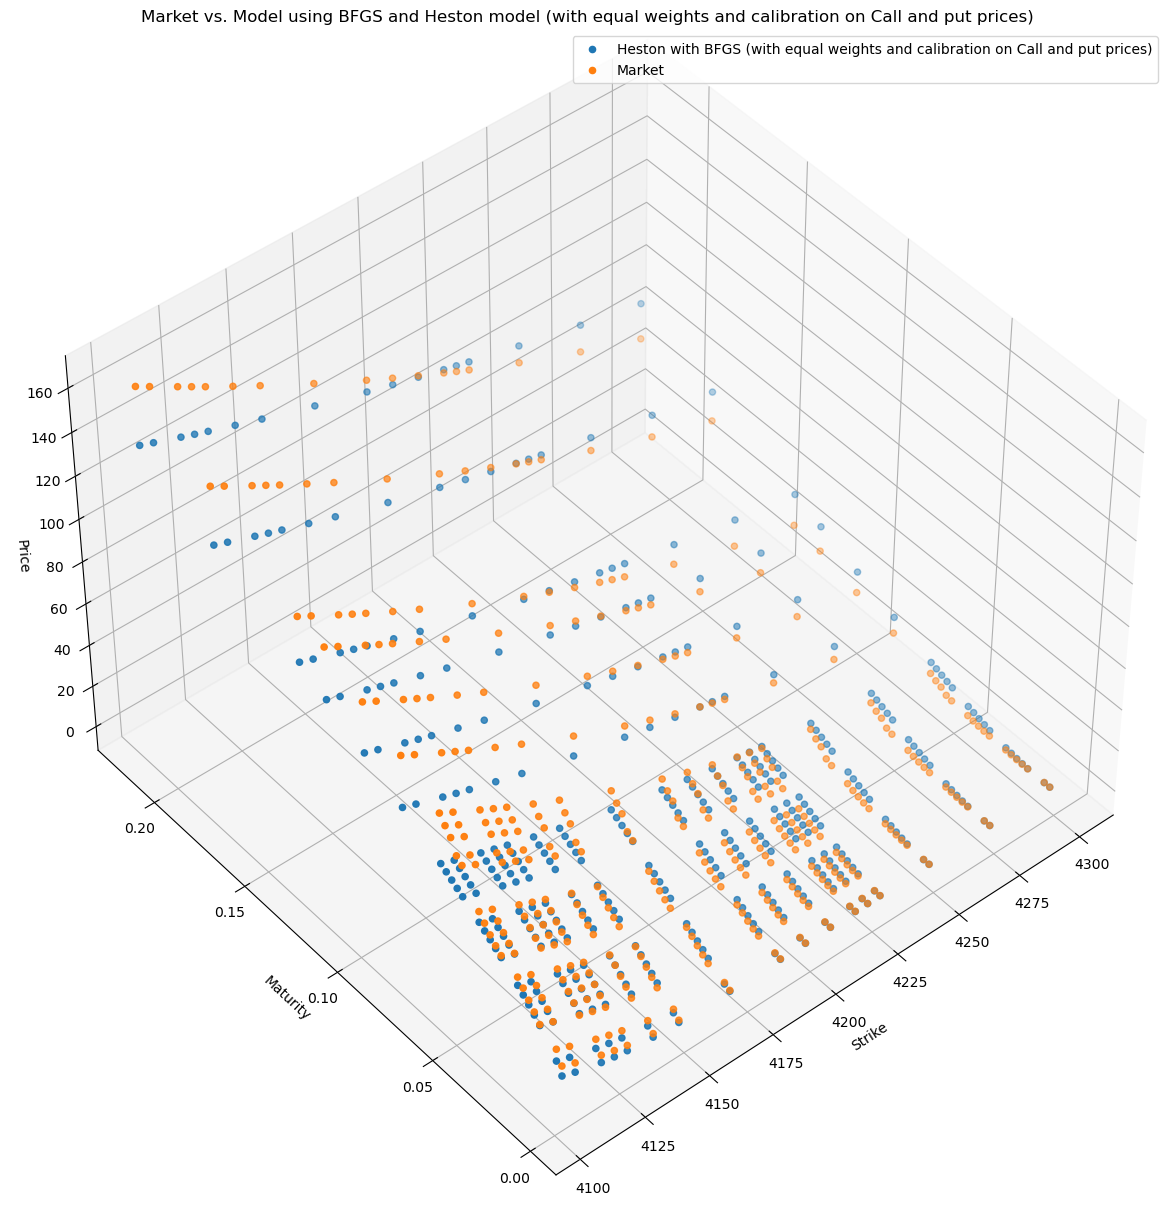

In [34]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices_pc.T, label='Heston with BFGS (with equal weights and calibration on Call and put prices)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with equal weights and calibration on Call and put prices)')

plt.legend()

plt.show()

## 1.1.d Heston with weights inversely proportional to bid-ask spread on Call & Put prices

In [35]:
params = [ 2.34548424, 0.06375792, 0.59865706, -0.43626748, -0.95937438]

# Parameters
alpha = 1.5
eta = 0.2
n = 12

model ='Heston'

def callbackF_full_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model, w, w_p)

num_iter = 1
[xopt_pc_w, fopt_pc_w, gopt_pc_w, Bopt_pc_w, func_calls_pc_w, grad_calls_pc_w, warnflg_pc_w] = fmin_bfgs(
        mfc.eValuefull_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full_w,
        maxiter=20,
        full_output=True, 
        retall=False)

 
i = 1
x_i = [ 2.34543232  0.06057074  0.59862431 -0.43606929 -0.98452827]
f_i = 16.153223290752752
 
i = 2
x_i = [ 2.3455017   0.06418362  0.59832765 -0.43587775 -0.98572011]
f_i = 15.917158054363158
 
i = 3
x_i = [ 2.35042628  0.05412734  0.38767425 -0.18154877 -0.9860408 ]
f_i = 14.074332148846993
 
i = 4
x_i = [ 2.34129286  0.04574274  0.30573994  0.28106768 -0.98690756]
f_i = 12.887163145046701
 
i = 5
x_i = [ 2.32665223  0.05007535  0.4962001   0.78039261 -0.98736054]
f_i = 12.258277777300565
 
i = 6
x_i = [ 2.22673468  0.05398794  0.41317925  0.67312783 -0.98715418]
f_i = 12.22529565238518
 
i = 7
x_i = [ 2.19887251  0.05629963  0.43045331  0.73395742 -0.98698714]
f_i = 12.17233138841139
 
i = 8
x_i = [ 2.12577327  0.06048217  0.43851084  0.82609758 -0.9865544 ]
f_i = 12.14653444237217
 
i = 9
x_i = [ 2.11270107  0.06040255  0.42104421  0.82667624 -0.98652819]
f_i = 12.140839270277452
 
i = 10
x_i = [ 2.05462792  0.06097409  0.38778002  0.8582367  -0.98647346]
f_i = 12.13510717

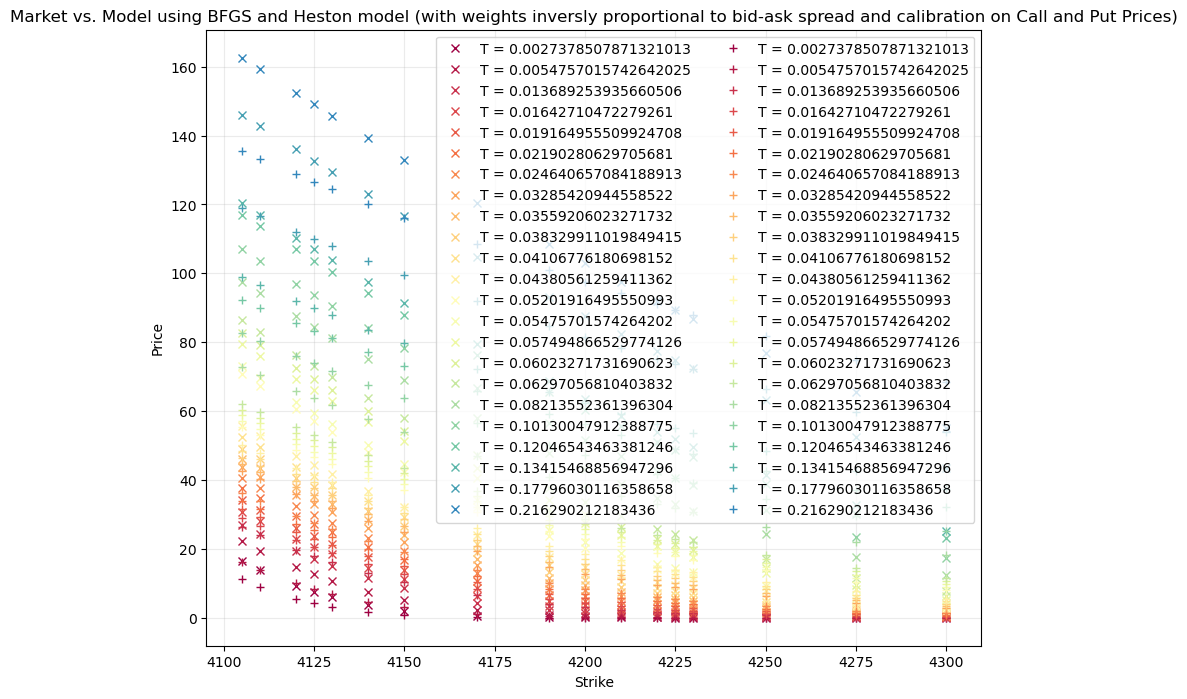

In [36]:
params2 = xopt_pc_w
lenT = len(maturities)
lenK = len(strikes)
modelPrices_pc_w = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_pc_w[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_pc_w[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread and calibration on Call and Put Prices)')
#plt.savefig('MarketvsModel_BFGS.png')
plt.show() 

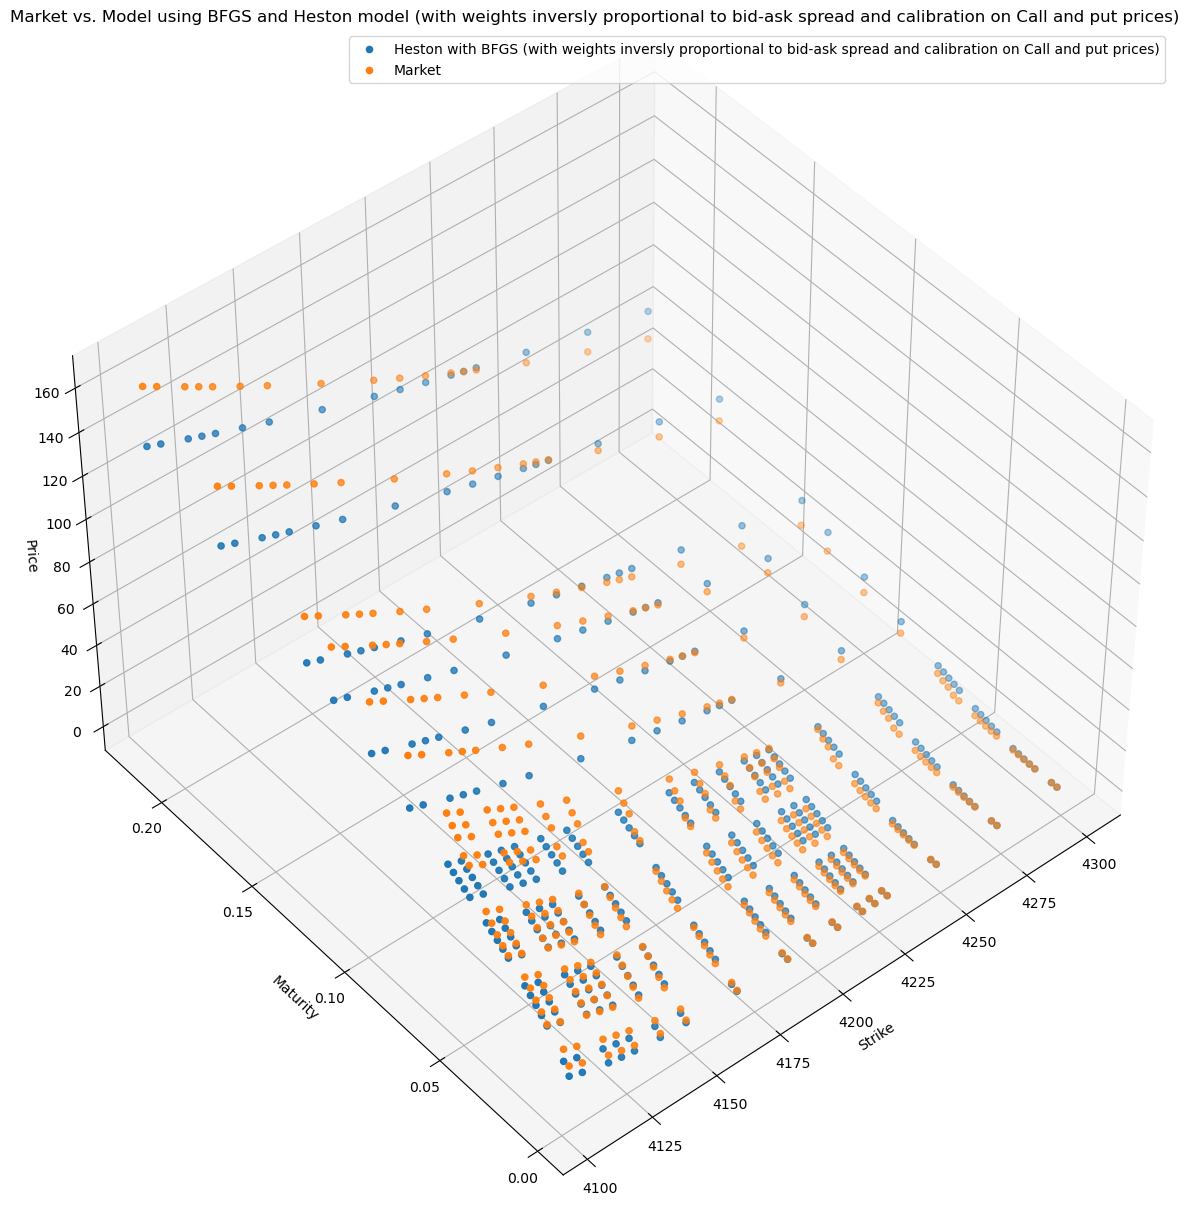

In [37]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices_pc_w.T, label='Heston with BFGS (with weights inversly proportional to bid-ask spread and calibration on Call and put prices)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread and calibration on Call and put prices)')

plt.legend()

plt.show()

# 1.2 VGSA model:

ΘVGSA = {σ, ν, θ, κ, η, λ}

## 1.2.a VGSA with equal weights on Call Prices

In [38]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model_v)

num_iter = 1
[xopt_v, fopt_v, gopt_v, Bopt_v, func_calls_v, grad_calls_v, warnflg_v] = fmin_bfgs(
        mfc.eValue,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF,
        maxiter=20,
        full_output=True, 
        retall=False)

6.314782183908005
6.314761177908677
6.314794915280337
6.314735959397373
6.314782211893761
6.314782180769975
6.314782183959068
51.61254295958128
51.61254295958897
51.6125429598005
51.61254295958098
51.61254295958114
51.61254295958124
51.61254295958132
123902531433.16956
117766962574.62431
109473250589.9518
132163467346.19774
130030318032.12843
124423565396.27554
108041754426.755
1554.3200194250874
1554.3200304117847
1554.3186900301894
1554.3201699558315
1554.3200186739193
1554.3200194492003
1554.3200194305243
49.45614808366735
49.45617156382418
49.45610657233308
49.456229489125036
49.456147988812845
49.45614809365504
49.45614808395662
3.8114633660966515
3.8114733727745236
3.8114563969000717
3.811485757113267
3.811463345702105
3.8114633684329293
3.8114633661315898
 
i = 1
x_i = [0.02412953 0.03801891 0.00667382 2.38917165 1.89090472 0.84004647]
3.8114633660966515
f_i = 3.8114633660966515
11.45820713261508
11.458218883012199
11.45820316332773
11.458219604436422
11.45820710356856
11.458207

In [39]:
xopt_v

array([0.02201809, 0.03707185, 0.00858907, 4.40381212, 0.57567413,
       1.05553105])

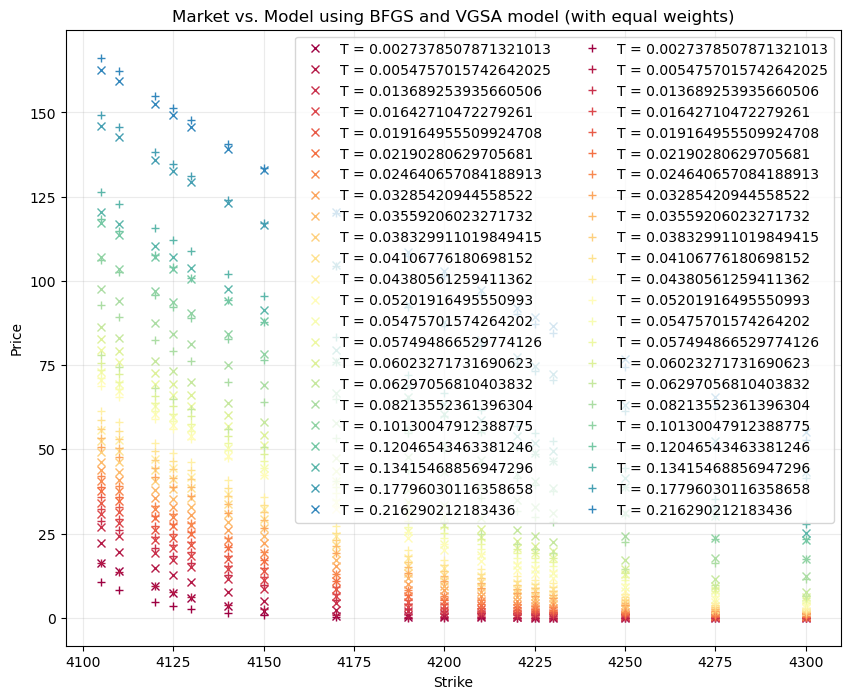

In [40]:
params2 = xopt_v
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model_v)
        modelPrices[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and VGSA model (with equal weights)')
plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


## 1.2.b VGSA with weights inversely proportional to bid-ask spread on Call prices

In [41]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model_v, w)

num_iter = 1
[xopt_v_w, fopt_v_w, gopt_v_w, Bopt_v_w, func_calls_v_w, grad_calls_v_w, warnflg_v_w] = fmin_bfgs(
        mfc.eValue_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_w,
        maxiter=20,
        full_output=True, 
        retall=False)

4.194365299468084
4.194352241425854
4.1943731098703045
4.194337418243462
4.19436531612836
4.194365297606574
4.194365299498152
33.48909991477731
33.48909991479321
33.489099915207625
33.48909991477664
33.489099914777064
33.489099914777235
33.48909991477738
10310677212.206112
9148226736.87956
14602478428.863794
12121802476.381157
8018623743.787641
10302343813.680382
9249060107.309277
1124.292653452149
1124.2926633243271
1124.2915911755422
1124.2927715001122
1124.2926529659771
1124.2926534672463
1124.2926534553071
31.35395711959494
31.353974451659212
31.353930154346646
31.35400895738603
31.35395706285284
31.353957125536542
31.353957119770506
2.7586532445134
2.758659675405733
2.758649423203719
2.7586639999808855
2.758653235524795
2.758653245534402
2.75865324453698
 
i = 1
x_i = [0.02411301 0.03803363 0.00659871 2.3891717  1.89090471 0.84004647]
2.7586532445134
f_i = 2.7586532445134
34.18604091441784
34.186040370183676
34.186021040292424
34.18608129575542
34.18604084002865
34.18604092734706


## 1.2.c VGSA with equal weights on Call & Put prices

In [42]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF_full(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model_v)

num_iter = 1
[xopt_v_pc, fopt_v_pc, gopt_v_pc, Bopt_v_pc, func_calls_v_pc, grad_calls_v_pc, warnflg_v_pc] = fmin_bfgs(
        mfc.eValuefull,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full,
        maxiter=20,
        full_output=True, 
        retall=False)

 
i = 1
x_i = [2.30923148e-02 3.89963337e-02 1.85247147e-03 2.38917374e+00
 1.89090449e+00 8.40046472e-01]
f_i = 13.464623041787542
 
i = 2
x_i = [ 3.65464860e-02  3.82657748e-02 -2.03828354e-03  2.38917001e+00
  1.89090496e+00  8.40046394e-01]
f_i = 11.013114563988871
 
i = 3
x_i = [ 4.00954142e-02  4.95569032e-02 -8.76928901e-04  2.38916188e+00
  1.89090614e+00  8.40046125e-01]
f_i = 10.530972464266782
 
i = 4
x_i = [ 3.74577268e-02  5.01925741e-02 -4.93994558e-05  2.27812215e+00
  1.90435743e+00  8.39616980e-01]
f_i = 9.818753550438256
 
i = 5
x_i = [3.52338495e-02 5.12963266e-02 6.32092302e-04 1.83775311e+00
 1.96927486e+00 8.33886161e-01]
f_i = 9.539568460694458
 
i = 6
x_i = [3.49656490e-02 5.27058615e-02 7.35587871e-04 1.32329156e+00
 2.03470895e+00 8.26895062e-01]
f_i = 9.396308983117484
 
i = 7
x_i = [3.49567079e-02 5.53358863e-02 7.30587466e-04 3.10987928e-01
 2.14590085e+00 8.13066222e-01]
f_i = 9.131506600489436
 
i = 8
x_i = [ 3.52052941e-02  6.00656456e-02  4.48195110e-04

## 1.2.d VGSA with weights inversely proportional to bid-ask spread on Call & Put prices

In [43]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF_full_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model_v, w, w_p)

num_iter = 1
[xopt_v_w_pc, fopt_v_w_pc, gopt_v_w_pc, Bopt_v_w_pc, func_calls_v_w_pc, grad_calls_v_w_pc, warnflg_v_w_pc] = fmin_bfgs(
        mfc.eValuefull_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full_w,
        maxiter=20,
        full_output=True, 
        retall=False)

 
i = 1
x_i = [2.31229849e-02 3.89918330e-02 1.82117049e-03 2.38917359e+00
 1.89090450e+00 8.40046472e-01]
f_i = 19.23825496897768
 
i = 2
x_i = [ 3.01081185e-02  3.82351913e-02 -1.83871436e-04  2.38917081e+00
  1.89090484e+00  8.40046433e-01]
f_i = 15.153752333195028
 
i = 3
x_i = [3.38786779e-02 4.80785156e-02 7.35069930e-04 2.38916725e+00
 1.89090535e+00 8.40046111e-01]
f_i = 14.292109748758524
 
i = 4
x_i = [ 3.30681797e-02  5.10611761e-02  4.23025329e-04 -7.69739113e-02
  2.25140704e+00  8.08912041e-01]
f_i = 13.189833559206718
 
i = 5
x_i = [ 3.35872179e-02  5.58043870e-02 -3.08540831e-05 -2.86949243e+00
  2.57586847e+00  7.72623996e-01]
f_i = 12.501968529098587
 
i = 6
x_i = [ 3.30121907e-02  5.57932380e-02 -3.11349714e-04 -3.93286845e+00
  2.69496083e+00  7.58859329e-01]
f_i = 12.457770386136666
 
i = 7
x_i = [ 3.32443396e-02  5.62911375e-02 -2.21129888e-04 -3.77919923e+00
  2.66959345e+00  7.61087130e-01]
f_i = 12.452851384242976
 
i = 8
x_i = [ 3.31785674e-02  5.59003057e-02 

# 1.3 Results of calibration for the different algorihtms:
    

In [44]:
df_param = pd.DataFrame({'Model':['Heston', 'Heston']*2,'Method':['BFGS with equal weights','BFGS with weights inversely proportional to bid-ask spread']*2, 'Prices':['Call']*2+['Call & Put']*2})

list_arg_heston = ['kappa','theta', 'sigma','rho', 'v0']
i=0
for para in list_arg_heston:
    df_param[para] = [xopt[i],xopt_w[i], xopt_pc[i], xopt_pc_w[i]]
    i+=1
    
df_param

Model                                             Method      Prices  \
0  Heston                            BFGS with equal weights        Call   
1  Heston  BFGS with weights inversely proportional to bi...        Call   
2  Heston                            BFGS with equal weights  Call & Put   
3  Heston  BFGS with weights inversely proportional to bi...  Call & Put   

      kappa     theta     sigma       rho        v0  
0  2.359482 -0.079593  0.599166 -1.000438 -0.955222  
1  4.261961 -0.059995  0.586308 -1.011792 -0.957226  
2  1.766603  0.071382  0.726466  0.874942 -0.962977  
3  1.477727  0.070810  0.328487  1.037407 -0.986714

In [45]:
df_param_v = pd.DataFrame({'Model':['VGSA', 'VGSA']*2,'Method':['BFGS with equal weights','BFGS with weights inversely proportional to bid-ask spread']*2, 'Prices':['Call']*2+['Call & Put']*2})

list_arg_vgsa = ['sigma','nu','theta','kappa', 'eta', 'lambda']
i=0
for para in list_arg_heston:
    df_param_v[para] = [xopt_v[i],xopt_v_w[i],xopt_v_pc[i],xopt_v_w_pc[i]]
    i+=1
    
df_param_v

Model                                             Method      Prices  \
0  VGSA                            BFGS with equal weights        Call   
1  VGSA  BFGS with weights inversely proportional to bi...        Call   
2  VGSA                            BFGS with equal weights  Call & Put   
3  VGSA  BFGS with weights inversely proportional to bi...  Call & Put   

      kappa     theta     sigma       rho        v0  
0  0.022018  0.037072  0.008589  4.403812  0.575674  
1  0.015901  0.019453  0.004377  4.082784  0.996404  
2  0.035141  0.059996 -0.000719 -4.036984  2.281511  
3  0.024837  0.031647 -0.000108 -3.425779  1.568084

# 2. Local volatility surface

In [82]:
def vol_surface(params, strikes, maturities, modelPrices, model, title_):
    Prices = modelPrices.T
    params2 = params
    lenT = 3 * len(maturities)
    lenK = 3 * len(strikes)
    h_strikes = (strikes[-1] - strikes[0]) / lenK
    h_maturities = (maturities[-1] - maturities[0]) / lenT
    strikes_l = np.arange(strikes[0], strikes[-1] + h_strikes, h_strikes)
    maturities_l = np.arange(maturities[0], maturities[-1] + h_maturities, h_maturities)
    lenT = len(maturities_l)
    lenK = len(strikes_l)
    Prices = np.zeros((lenK, lenT))

    print('Computing the prices according to the model and the opt-parameters')
    for i in tqdm(range(lenK)):
        for j in range(lenT):
            T = maturities_l[j]
            K = strikes_l[i]
            [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
            Prices[i, j] = cT_km[0]

    sig_loc = np.zeros((lenK, lenT))
    print('Computing the local volatility surface')
    for i in tqdm(range(1, lenK - 1)):
        for j in range(1, lenT - 1):
            dC_dt = (Prices[i, j + 1] - Prices[i, j - 1]) / (maturities_l[j + 1] - maturities_l[j - 1])
            dC_dK = (Prices[i + 1, j] - Prices[i - 1, j]) / (strikes_l[i + 1] - strikes_l[i - 1])
            dC2_dK2 = (Prices[i + 1, j] - 2 * Prices[i, j] + Prices[i - 1, j]) / ((strikes_l[i + 1] - strikes_l[i]) * (strikes_l[i] - strikes_l[i - 1]))
            sig_loc[i, j] = np.sqrt(2 * (dC_dt + q * Prices[i, j] + (r - q) * strikes_l[i] * dC_dK) / (strikes_l[i] ** 2 * dC2_dK2))

    print(60 * '=')
    # create a meshgrid of the maturities and strikes
    maturities_, strikes_ = np.meshgrid(maturities_l[1:-1], strikes_l[1:-1])

    sig_loc_ = sig_loc[1:-1, 1:-1]
    print(np.shape(maturities_))
    print(np.shape(sig_loc_))

    # show plot
    fig = plt.figure(figsize=[15, 15])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(strikes_, maturities_, sig_loc_, cmap='rainbow')#cm.coolwarm, vmin=-1, vmax=1)
    #ax.scatter(strikes_, maturities_, sig_loc_, label='Local Volatility Surface')
    #ax.plot_wireframe(strikes_, maturities_, sig_loc_, label='Local Volatility Surface',cmap=cm.coolwarm)
    ax.view_init(elev=22, azim=160)
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('Local Volatility')
    ax.set_title(title_)

    plt.show()


''' As for the models, the results seem slightly better using with weights inversely proportional to bid-ask spread instead of equal weights, we will plot the local volatility surfaces for both VGSA and Heston model using the parameters obtained with with weights inversely proportional to bid-ask spread.'''

## 2.1 Local Volatility Surface for Heston model

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [03:09<00:00,  2.21s/it]


Computing the local volatility surface


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 522.52it/s]


(84, 115)
(84, 115)


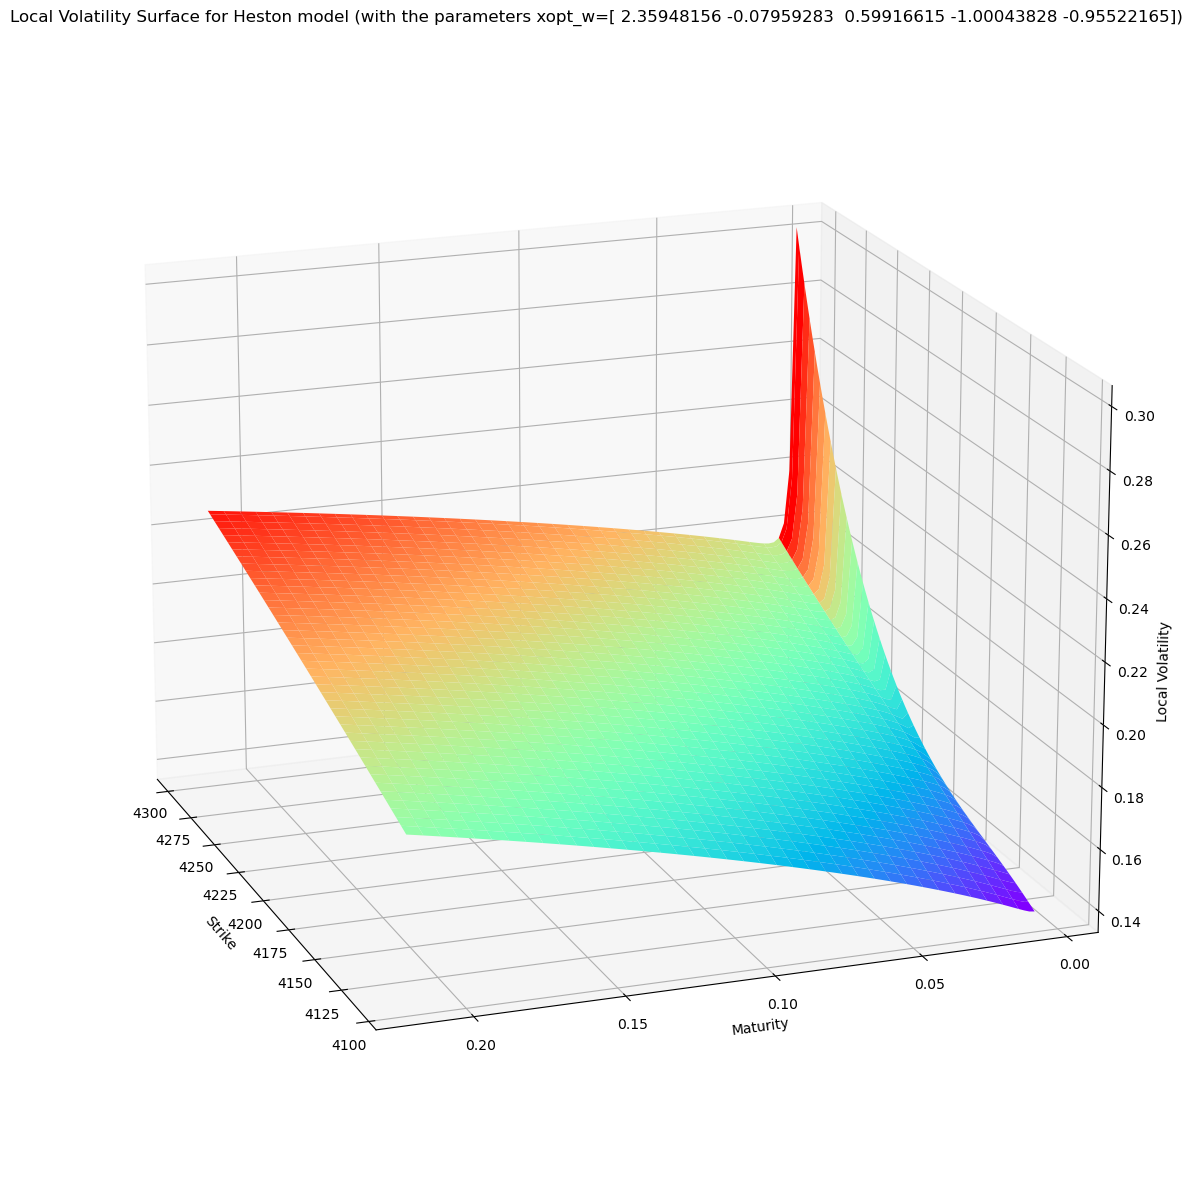

In [73]:
params_ = xopt_pc
model_ = 'Heston'
title_ = f'Local Volatility Surface for Heston model (with the parameters xopt_w={xopt})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [03:18<00:00,  2.31s/it]


Computing the local volatility surface


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 965.83it/s]


(84, 115)
(84, 115)


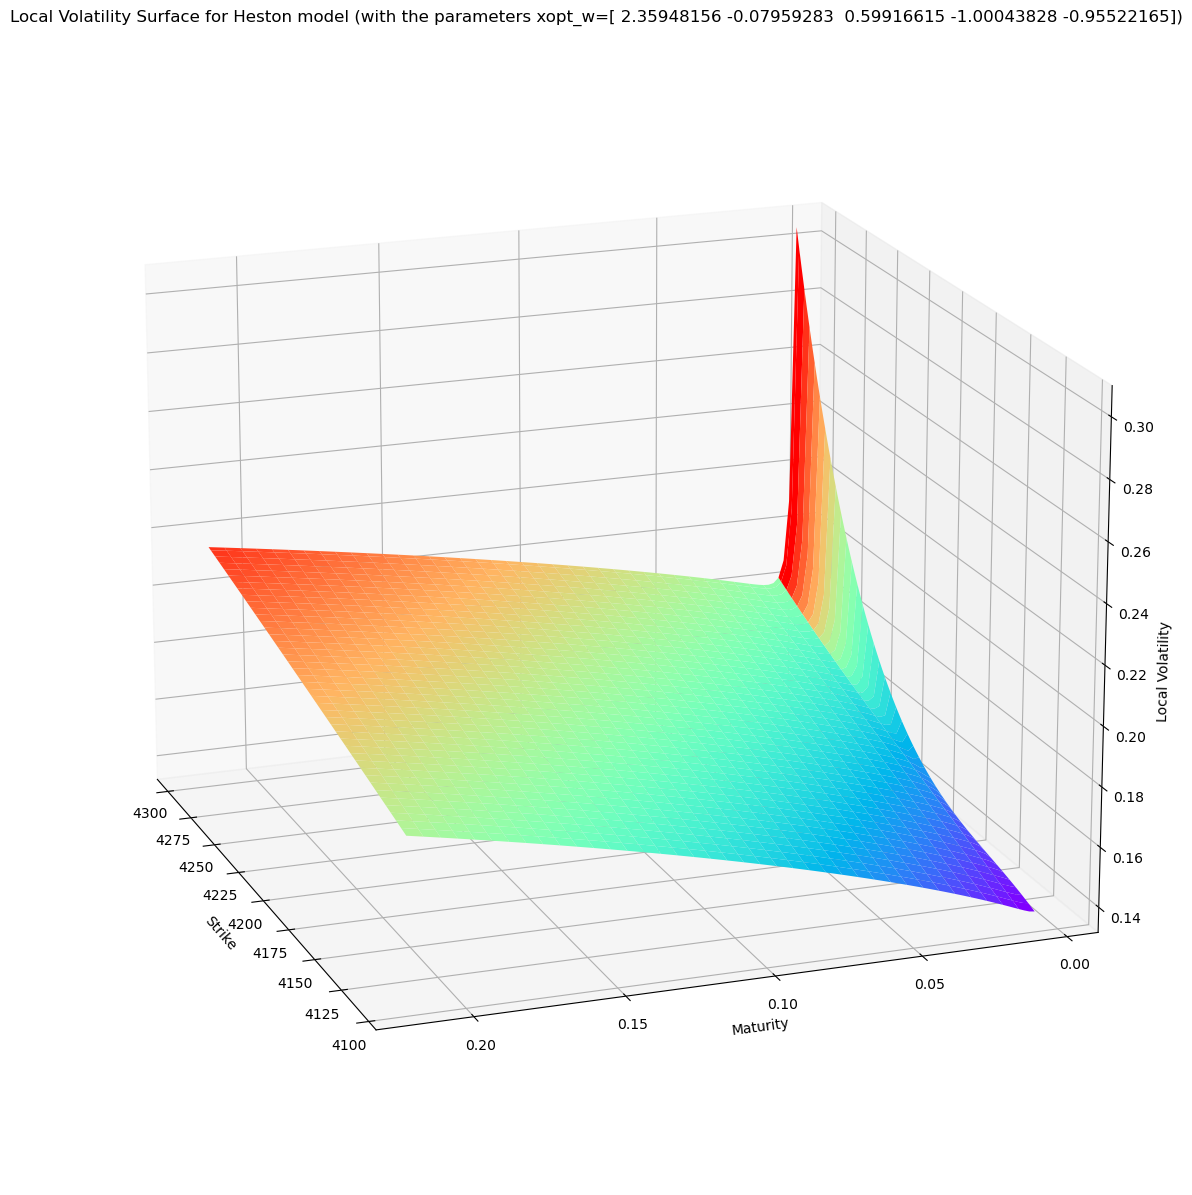

In [74]:
params_ = xopt_pc_w
model_ = 'Heston'
title_ = f'Local Volatility Surface for Heston model (with the parameters xopt_w={xopt})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

## 2.2 Local Volatility Surface for VGSA model

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [01:07<00:00,  1.27s/it]


Computing the local volatility surface


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1948.88it/s]


(51, 68)
(51, 68)


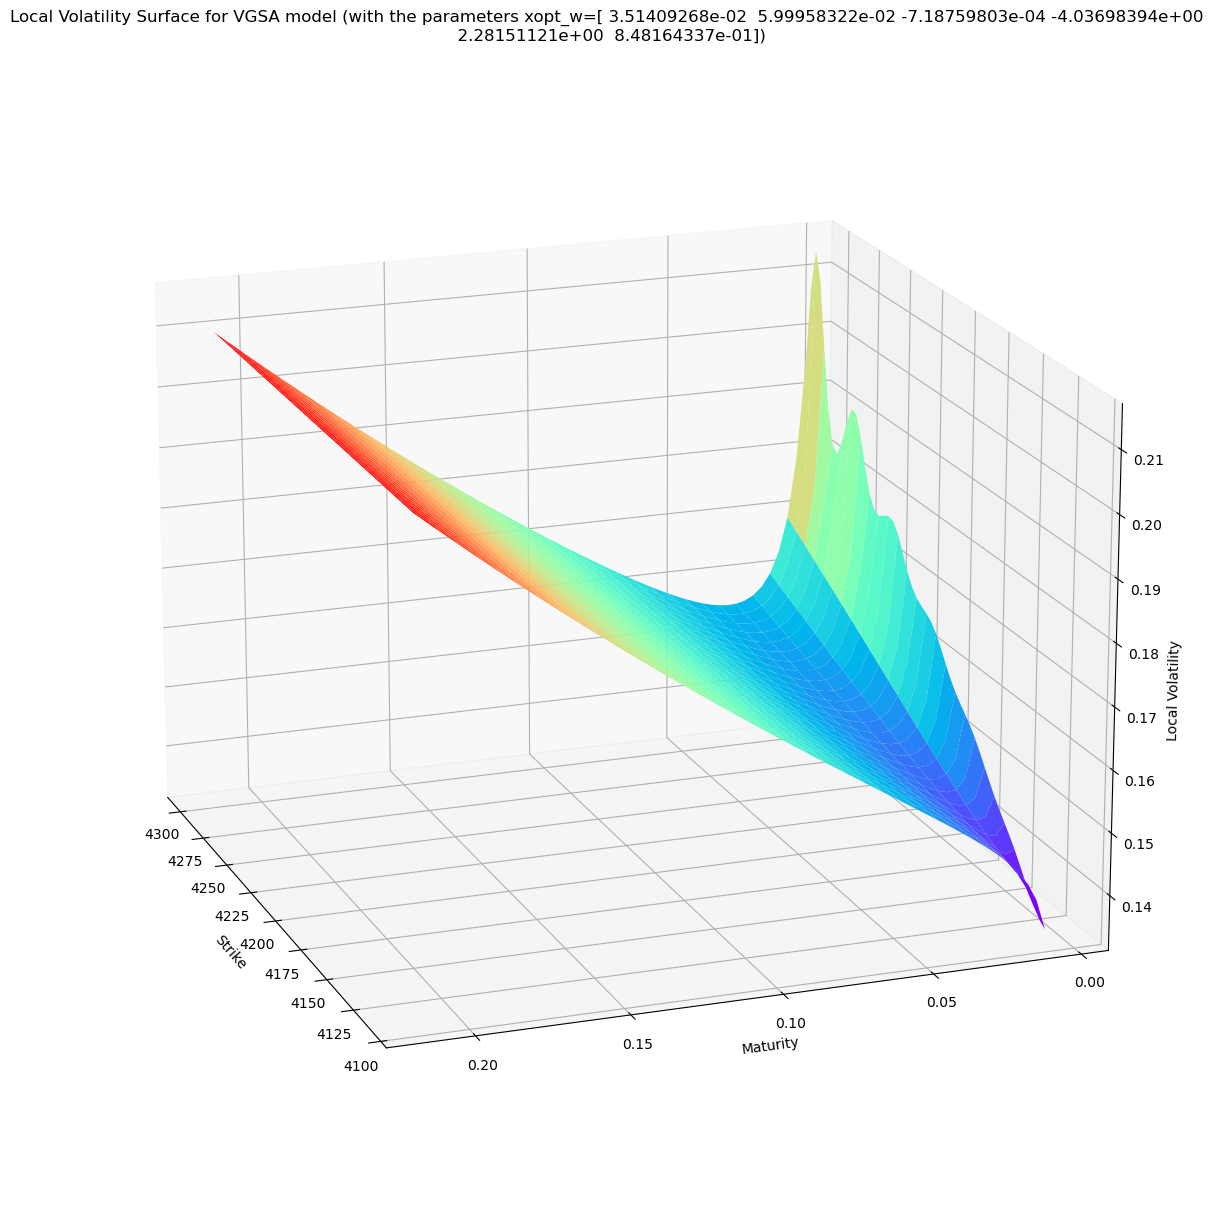

In [81]:
params_ = xopt_v_pc
model_ = 'VGSA'
title_ = f'Local Volatility Surface for {model_} model (with the parameters xopt_w={params_})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [01:07<00:00,  1.27s/it]


Computing the local volatility surface


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 2214.20it/s]


(51, 68)
(51, 68)


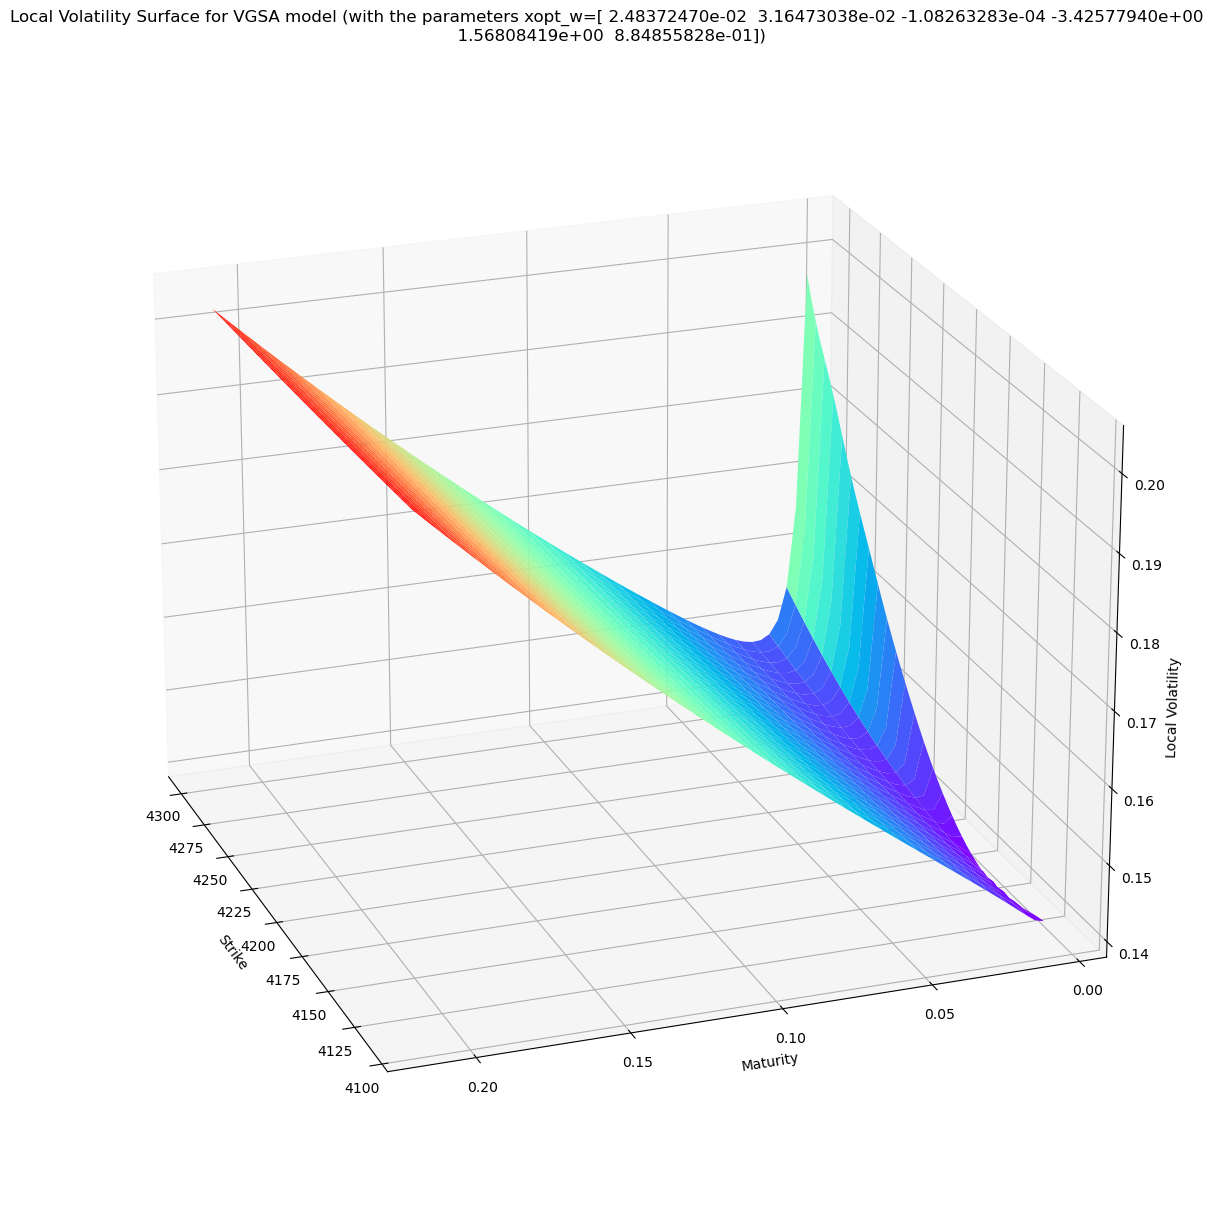

In [83]:
params_ = xopt_v_w_pc
model_ = 'VGSA'
title_ = f'Local Volatility Surface for {model_} model (with the parameters xopt_w={params_})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

# 3. Findings/Observations

The Heston model assumes a constant correlation between the underlying asset and volatility, while the VGSA model allows for a varying correlation. This results in differences in the local volatility surface between the two models.The VGSA model is more flexible than the Heston model in terms of fitting market data. It can capture different shapes and behaviors of the implied volatility surface more accurately. We can see the surface for VGSA is indeed slightly more complex as can be seen for low maturity near the spot price. 

We can see the surfaces obtained for the 2 models the convexity of the surface are different. The slightly concave form of the surface at higher maturity for Heston is an element that makes this model more robust in a certain way here whereas VSGA is less optimist at longer term than Heston according its local vol surface.
Moreover, the VGSA model may have produced a smoother local volatility surface compared to the Heston model, which can exhibit more volatility and fluctuations.


Additionnal Notes : 

Here high local vol values at very low maturity for call options indicate that investors perceive a high probability of significant SP500 stock price movements in the very near future, which translates into high implied volatility for these options. This may be due to impending events such as major corporate announcements, quarterly earnings, macroeconomic events, which are happening in the beginning of the year or other events. 